In [ ]:
import numpy as np
import gpflow
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import tensorflow as tf
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel as C ,WhiteKernel)


from gpflow.kernels import RationalQuadratic, Constant,Linear, White, Matern12, Matern32, Matern52, RBF, Cosine, Periodic


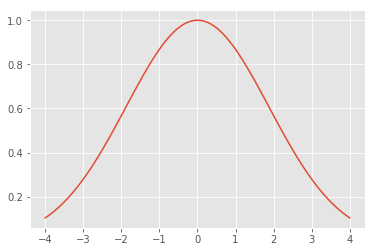

In [50]:
x=np.linspace(-4.,4.,100)
y=np.exp(-1.*(x)**2/(2.66**2))

plt.plot(x,y)

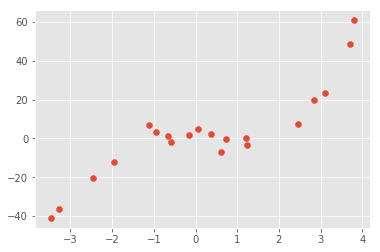

In [88]:
def  f(x):
    return x**3

N=20
#rng = np.random.RandomState(1)
x_train=np.random.uniform(low=-4, high=4, size=(N,))
y_train=f(x_train)+np.random.normal(loc=0., scale=5., size=(N,))
x_test=np.linspace(-4.,4., 100)

plt.scatter(x_train, y_train)
plt.show()


In [89]:
import matplotlib.pyplot as plt
# Square Exponential Kernel (otherwise known as Gaussian)
def cov_kernel(x1,x2,h,lam):
    return np.exp(-1.*(x1-x2)**2/(lam**2))
# Make covariance matrix from the covatriance kernel

# Make covariance matrix from the covatriance kernel

def make_K(x,h,lam):
    K=np.zeros([len(x), len(x)])
    for i in range(len(x)):
        for j in range(len(x)):
            K[i,j]=cov_kernel(x[i], x[j], h, lam)
    return K
def make_K1(x,y,h,lam):
    K=np.zeros([len(x), len(x)])
    for i in range(len(x)):
        for j in range(len(x)):
            K[i,j]=cov_kernel(x[i], x[j], h, lam)*cov_kernel(y[i], y[j], h, lam)
    return K

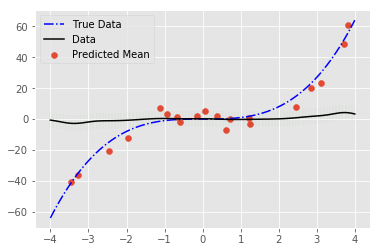

In [91]:
h, lam=1,.5
K1=make_K1(x_train,x_train, h, lam)

sigma=5.
iK=np.linalg.inv(K1+sigma**2*np.identity(np.shape(K1)[0]))


mu=[]; sig=[]
for xx in x_test:
    K_x=cov_kernel(xx, x_train, h, lam)
    K_xx=cov_kernel(xx,xx,h,lam)
    mu_xx=np.dot(K_x.T,np.dot(iK,y_train))
    sig_xx=K_xx+sigma**2-np.dot(K_x.T, np.dot(iK,K_x))
    mu.append(mu_xx)
    sig.append(np.sqrt(np.abs(sig_xx)))
    
plt.plot(x_test,f(x_test),'-.b')
plt.scatter(x_train, y_train)

plt.plot(x_test, mu,'k')
plt.errorbar(x_test, mu, yerr=sig, capsize=0, color='g', alpha=0.03)
plt.legend([ 'True Data','Data', 'Predicted Mean'])


# GPflow

In [58]:
X=x_train[:,None]
Y=y_train[:,None]

In [44]:
with gpflow.defer_build():
    k = RBF(1)+White(1)+Linear(1)*Linear(1)#+Cosine(1)#+Matern12(1)RationalQuadratic(1)# 
    l = gpflow.likelihoods.Gaussian()
    m = gpflow.models.GPMC(X, Y, k,l)
    m.likelihood.variance = 0.01
#print(m)

In [45]:
m.kern.kernels[1].variance=10.

In [46]:
def plot(m):
    xx = np.linspace(X.min(), X.max(), 100).reshape(100, 1)
    mean, var = m.predict_y(xx)
   # plt.figure(figsize=(12, 6))
    plt.plot(xx,f(xx),'b')
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
    plt.ylim([-100,100])



INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -76.060319
  Number of iterations: 798
  Number of functions evaluations: 992


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -76.060319
  Number of iterations: 798
  Number of functions evaluations: 992


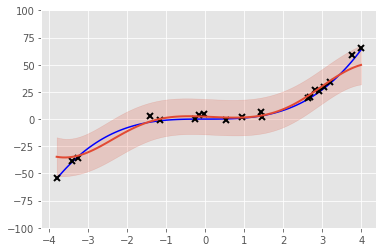

In [47]:
#MLE
m.compile()
gpflow.train.ScipyOptimizer().minimize(m)
m.as_pandas_table()
plot(m)
